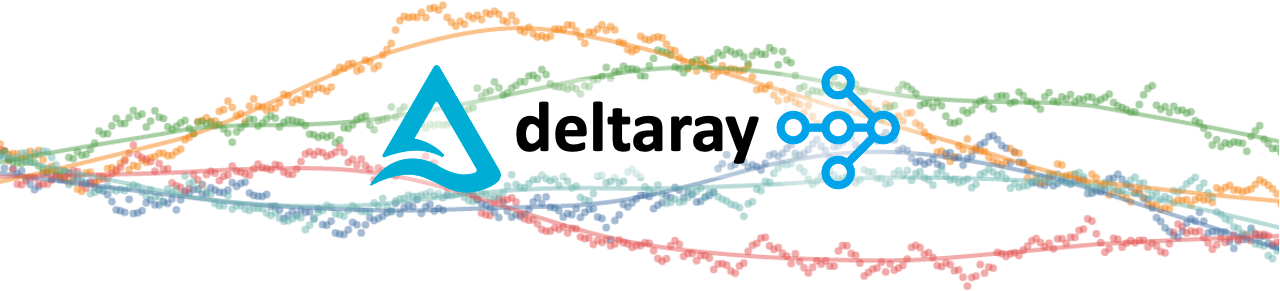

The [`deltaray`](https://github.com/delta-incubator/deltaray) library supports easy creation of [Ray Datasets](https://docs.ray.io/en/latest/data/dataset.html) from a [Delta Table](https://delta.io/). This notebook will walk you through an example of using deltaray as part of a larger training scenario with [`ray`](https://docs.ray.io/en/latest/) and both [`scikit-learn`](https://scikit-learn.org/stable/) and [`xgboost`](https://xgboost.readthedocs.io/en/stable/python/python_intro.html).

## <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>
- [Environment Setup:](#Environment-Setup)
    - [Import Libraries](#Import-Libraries)
    - [Initialize Ray Cluster](#Initialize-Ray-Cluster)
    - [Create Delta Table](#Create-Delta-Table)
- [Use `deltaray` to Read the Delta Table](#Use-deltaray-to-Read-the-Delta-Table)
- [Model Training:](#Model-Training)
    - [Define Ray Tune Search Space](#Define-Ray-Tune-Search-Space)
    - [Run Batch Training on Ray Tune](#Run-Batch-Training-on-Ray-Tune)

## Environment Setup

### Import Libraries

In [1]:
import time

import deltaray
import deltalake as dl
import pandas as pd

import ray
from ray import air, tune
from ray.air import session
from ray.air.checkpoint import Checkpoint

import sklearn
from sklearn.datasets import make_regression
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

import xgboost as xgb

### Initialize Ray Cluster

In [2]:
if ray.is_initialized():
    ray.shutdown()
ray.init()

2023-03-17 12:35:03,116	INFO worker.py:1553 -- Started a local Ray instance.


Python version:,3.10.9
Ray version:,2.3.0


### Create Delta Table

In [3]:
# Generate Synthetic Data
X, y = make_regression(n_samples=1_000_000, n_features=20, n_informative=7, random_state=42, )
df_X = pd.DataFrame(X, columns=[f'x{n}' for n in range(20)], )
df_y = pd.DataFrame(y, columns=['target'], )
df = pd.concat([df_y, df_X, ], axis=1, )

# Save as Delta Table
dl.write_deltalake('./delta-table', df)

## Use `deltaray` to Read the Delta Table

In [4]:
# Load Delta Table into a Ray Dataset
dataset = deltaray.read_delta('./delta-table')
dataset

(_get_read_tasks pid=11573) /opt/homebrew/Caskroom/miniforge/base/envs/deltaray-demo/lib/python3.10/site-packages/ray/data/datasource/parquet_datasource.py:233: FutureWarning: 'ParquetDataset.pieces' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Use the '.fragments' attribute instead
(_get_read_tasks pid=11573)   pq_ds.pieces, **prefetch_remote_args
(_get_read_tasks pid=11573) /opt/homebrew/Caskroom/miniforge/base/envs/deltaray-demo/lib/python3.10/site-packages/ray/data/datasource/parquet_datasource.py:311: FutureWarning: 'ParquetDataset.pieces' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Use the '.fragments' attribute instead
(_get_read_tasks pid=11573)   num_files = len(self._pq_ds.pieces)
(_get_read_tasks pid=11573) /opt/homebrew/Caskroom/miniforge/base/envs/deltaray-demo/lib/python3.10/site-packages/ray/data/datasource/parquet_datasource.py:324: FutureWarning: 'ParquetDataset.pieces' attribute is deprec

Parquet Files Sample: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
(_get_read_tasks pid=11573) /opt/homebrew/Caskroom/miniforge/base/envs/deltaray-demo/lib/python3.10/site-packages/ray/data/datasource/parquet_datasource.py:263: FutureWarning: 'ParquetDataset.pieces' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Use the '.fragments' attribute instead
(_get_read_tasks pid=11573)   np.array_split(self._pq_ds.pieces, parallelism),


## Model Training

### Define Ray Tune Search Space

<div class="alert alert-block alert-info">
<b>💡Note:</b> Common search algorithms include grid search, random search, and Bayesian optimization. The best strategy for exploring your search space will depend on your data, problem, and model. It's worthwhile trying different approaches to build your intuition.
</div>

In [5]:
# Ray Tune will allow us to quickly and efficiently test combinations of 
# `algorithm` and `sample size` to see how model performance is affected.
search_space = {
  'algorithm': tune.grid_search(
    [LinearRegression(fit_intercept=True), xgb.XGBRegressor(max_depth=4)]
  ),
  'sample_size': tune.grid_search([1_000, 50_000, 100_000, ])
}

### Run Batch Training on Ray Tune

In [6]:
# Define a custom train function for Ray Tune
def train_model(config: dict) -> None:

    algorithm = config["algorithm"]
    sample_size = config["sample_size"]
    
    df = dataset.limit(sample_size).to_pandas()

    # Train/valid split
    train_df, valid_df = train_test_split(df, test_size=0.2, shuffle=True)
    train_X = train_df[[f'x{n}' for n in range(20)]]
    train_y = train_df['target']
    valid_X = valid_df[[f'x{n}' for n in range(20)]]
    valid_y = valid_df['target']

    # Train model
    model = algorithm.fit(train_X, train_y)
    pred_y = model.predict(valid_X)

    # Evaluate
    error = sklearn.metrics.mean_absolute_error(valid_y, pred_y)

    # Define a model checkpoint using AIR API.
    # https://docs.ray.io/en/latest/tune/tutorials/tune-checkpoints.html
    checkpoint = ray.air.checkpoint.Checkpoint.from_dict(
        {"model": algorithm, }
    )

    # Save checkpoint and report back metrics, using ray.air.session.report()
    # The metrics you specify here will appear in Tune summary table.
    # They will also be recorded in Tune results under `metrics`.
    metrics = dict(error=error)
    session.report(metrics, checkpoint=checkpoint)

In [7]:
# Define a tuner object using Ray AIR Tuner API
tuner = tune.Tuner(
    train_model,
    param_space=search_space,
    run_config=air.RunConfig(
        # redirect logs to relative path instead of default ~/ray_results/
        local_dir="my_tune_logs",
        name="batch_tuning",
        # Set Ray Tune verbosity. Print summary table only with levels 2 or 3.
        verbose=2,
    ),
)

# Run the experiment with Ray Tune
start = time.time()
results = tuner.fit()
total_time_taken = time.time() - start

# Print training stats
print(f"Total number of models: {len(results)}")
print(f"TOTAL TIME TAKEN: {total_time_taken:.2f} seconds")
best_result = results.get_best_result(metric="error", mode="min").config
print(f"Best result: {best_result}")

Trial name,error,should_checkpoint
train_model_dbda7_00000,6.28438e-13,True
train_model_dbda7_00001,39.4593,True
train_model_dbda7_00002,3.11438e-13,True
train_model_dbda7_00003,14.2775,True
train_model_dbda7_00004,2.51909e-13,True
train_model_dbda7_00005,12.9575,True


2023-03-17 12:35:25,914	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algorithm': LinearRegression()}
2023-03-17 12:35:26,536	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algorithm': LinearRegression()}
2023-03-17 12:35:26,727	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algorithm': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
  

Total number of models: 6
TOTAL TIME TAKEN: 8.64 seconds
Best result: {'algorithm': LinearRegression(), 'sample_size': 100000}


In [8]:
# DataFrame with all results
results.get_dataframe()

,error,time_this_iter_s,should_checkpoint,done,timesteps_total,episodes_total,training_iteration,trial_id,experiment_id,date,...,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,warmup_time,config/algorithm,config/sample_size,logdir
0,6.284377e-13,1.458030,True,False,NaN,NaN,1,dbda7_00000,d607e81f7df645deb9eaae2ffb4e9661,2023-03-17_12-35-25,...,11599,jamess-mbp.lan,127.0.0.1,1.458030,0,1,0.002002,LinearRegression(),1000,/Users/jameshibbard/PycharmProjects/deltaray-d...
1,3.945933e+01,0.217295,True,False,NaN,NaN,1,dbda7_00001,b2512e67ffc847b38eaed8fe2dd9c5b3,2023-03-17_12-35-26,...,11608,jamess-mbp.lan,127.0.0.1,0.217295,0,1,0.003869,"XGBRegressor(base_score=None, booster=None, ca...",1000,/Users/jameshibbard/PycharmProjects/deltaray-d...
2,3.114382e-13,0.080312,True,False,NaN,NaN,1,dbda7_00002,cb529c6f93b8405e9c19b1267c0efcd6,2023-03-17_12-35-26,...,11609,jamess-mbp.lan,127.0.0.1,0.080312,0,1,0.004151,LinearRegression(),50000,/Users/jameshibbard/PycharmProjects/deltaray-d...
3,1.427750e+01,3.836859,True,False,NaN,NaN,1,dbda7_00003,4cb543af647141a0ba259f19ae73ad9a,2023-03-17_12-35-30,...,11610,jamess-mbp.lan,127.0.0.1,3.836859,0,1,0.002875,"XGBRegressor(base_score=None, booster=None, ca...",50000,/Users/jameshibbard/PycharmProjects/deltaray-d...
4,2.519094e-13,1.086597,True,False,NaN,NaN,1,dbda7_00004,84346c420dbf4ec89c4afc8bdd4d0b13,2023-03-17_12-35-27,...,11611,jamess-mbp.lan,127.0.0.1,1.086597,0,1,0.003460,LinearRegression(),100000,/Users/jameshibbard/PycharmProjects/deltaray-d...
5,1.295750e+01,4.823784,True,False,NaN,NaN,1,dbda7_00005,afff3f7c815a47ee8d299827a2585a75,2023-03-17_12-35-31,...,11612,jamess-mbp.lan,127.0.0.1,4.823784,0,1,0.002962,"XGBRegressor(base_score=None, booster=None, ca...",100000,/Users/jameshibbard/PycharmProjects/deltaray-d...
